In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
from PIL import Image
from tqdm import tqdm
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
outer_names = ['test','train']
inner_names = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
os.makedirs('data', exist_ok=True)
for outer_name in outer_names:
    os.makedirs(os.path.join('data',outer_name), exist_ok=True)
    for inner_name in inner_names:
        os.makedirs(os.path.join('data',outer_name,inner_name), exist_ok=True)

In [9]:
angry = 0
disgusted = 0
fearful = 0
happy = 0
sad = 0
surprised = 0
neutral = 0
angry_test = 0
disgusted_test = 0
fearful_test = 0
happy_test = 0
sad_test = 0
surprised_test = 0
neutral_test = 0

In [10]:
def atoi(s):
    n = 0
    for i in s:
        n = n*10 + ord(i) - ord("0")
    return n


In [11]:
df = pd.read_csv('/kaggle/input/fer2013csv/fer2013.csv')
mat = np.zeros((48,48),dtype=np.uint8)
print("Saving images...")
print(mat)

Saving images...
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
# read the csv file line by line
for i in tqdm(range(len(df))):
    txt = df['pixels'][i]
    words = txt.split()
    
    # the image size is 48x48
    for j in range(2304):
        xind = j // 48
        yind = j % 48
        mat[xind][yind] = atoi(words[j])

    img = Image.fromarray(mat)

    # train
    if i < 28709:
        if df['emotion'][i] == 0:
            img.save('/kaggle/working/data/train/angry/im'+str(angry)+'.png')
            angry += 1
        elif df['emotion'][i] == 1:
            img.save('/kaggle/working/data/train/disgusted/im'+str(disgusted)+'.png')
            disgusted += 1
        elif df['emotion'][i] == 2:
            img.save('/kaggle/working/data/train/fearful/im'+str(fearful)+'.png')
            fearful += 1
        elif df['emotion'][i] == 3:
            img.save('/kaggle/working/data/train/happy/im'+str(happy)+'.png')
            happy += 1
        elif df['emotion'][i] == 4:
            img.save('/kaggle/working/data/train/sad/im'+str(sad)+'.png')
            sad += 1
        elif df['emotion'][i] == 5:
            img.save('/kaggle/working/data/train/surprised/im'+str(surprised)+'.png')
            surprised += 1
        elif df['emotion'][i] == 6:
            img.save('/kaggle/working/data/train/neutral/im'+str(neutral)+'.png')
            neutral += 1

    # test
    else:
        if df['emotion'][i] == 0:
            img.save('/kaggle/working/data/test/angry/im'+str(angry_test)+'.png')
            angry_test += 1
        elif df['emotion'][i] == 1:
            img.save('/kaggle/working/data/test/disgusted/im'+str(disgusted_test)+'.png')
            disgusted_test += 1
        elif df['emotion'][i] == 2:
            img.save('/kaggle/working/data/test/fearful/im'+str(fearful_test)+'.png')
            fearful_test += 1
        elif df['emotion'][i] == 3:
            img.save('/kaggle/working/data/test/happy/im'+str(happy_test)+'.png')
            happy_test += 1
        elif df['emotion'][i] == 4:
            img.save('/kaggle/working/data/test/sad/im'+str(sad_test)+'.png')
            sad_test += 1
        elif df['emotion'][i] == 5:
            img.save('/kaggle/working/data/test/surprised/im'+str(surprised_test)+'.png')
            surprised_test += 1
        elif df['emotion'][i] == 6:
            img.save('/kaggle/working/data/test/neutral/im'+str(neutral_test)+'.png')
            neutral_test += 1

print("Done!")

100%|██████████| 35887/35887 [02:05<00:00, 284.86it/s]

Done!


In [13]:

import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [27]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

In [15]:
# Define data generators
train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen
val_datagen

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')





Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [31]:
validation_generator[0]

(array([[[[0.5921569 ],
          [0.5764706 ],
          [0.40784317],
          ...,
          [0.58431375],
          [0.5803922 ],
          [0.58431375]],
 
         [[0.58431375],
          [0.54901963],
          [0.3803922 ],
          ...,
          [0.58431375],
          [0.58431375],
          [0.58431375]],
 
         [[0.5803922 ],
          [0.5294118 ],
          [0.36078432],
          ...,
          [0.5803922 ],
          [0.5882353 ],
          [0.5803922 ]],
 
         ...,
 
         [[0.4784314 ],
          [0.4784314 ],
          [0.48235297],
          ...,
          [0.46274513],
          [0.454902  ],
          [0.4431373 ]],
 
         [[0.47058827],
          [0.4784314 ],
          [0.4784314 ],
          ...,
          [0.45098042],
          [0.45098042],
          [0.43921572]],
 
         [[0.47058827],
          [0.47058827],
          [0.47450984],
          ...,
          [0.43921572],
          [0.43921572],
          [0.4431373 ]]],
 
 
        [

In [17]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [19]:
 model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.000),metrics=['accuracy'])


In [21]:
model_info = model.fit(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=num_val // batch_size)


Epoch 1/10
448/448 [==============================] - 221s 494ms/step - loss: 1.4417 - accuracy: 0.4410 - val_loss: 1.3042 - val_accuracy: 0.4943
Epoch 2/10
448/448 [==============================] - 223s 498ms/step - loss: 1.2883 - accuracy: 0.5054 - val_loss: 1.2012 - val_accuracy: 0.5353
Epoch 3/10
448/448 [==============================] - 230s 514ms/step - loss: 1.2050 - accuracy: 0.5414 - val_loss: 1.1537 - val_accuracy: 0.5586
Epoch 4/10
448/448 [==============================] - 223s 498ms/step - loss: 1.1461 - accuracy: 0.5644 - val_loss: 1.1342 - val_accuracy: 0.5706
Epoch 5/10
448/448 [==============================] - 220s 491ms/step - loss: 1.0942 - accuracy: 0.5831 - val_loss: 1.0960 - val_accuracy: 0.5886
Epoch 6/10
448/448 [==============================] - 219s 490ms/step - loss: 1.0455 - accuracy: 0.6038 - val_loss: 1.0901 - val_accuracy: 0.5891
Epoch 7/10
448/448 [==============================] - 219s 490ms/step - loss: 1.0077 - accuracy: 0.6198 - val_loss: 1.0827 -

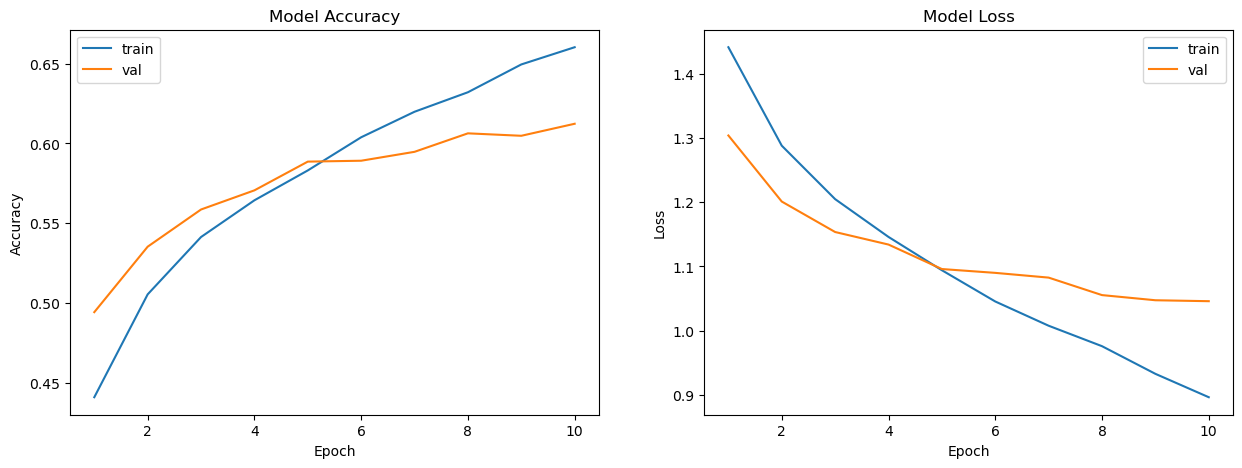

In [28]:
plot_model_history(model_info)

In [58]:
fig=plt.figure()
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
y = fig.add_subplot(3,4,num+1)
test_pred = int(np.argmax(model.predict(validation_generator)[1]))


113/113 [==============================] - 12s 108ms/step


In [59]:
test_pred

2

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 217, in assert_input_compatibility
        f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "sequential" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 48, 48, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 7) dtype=float32>]


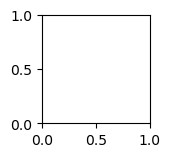

In [83]:
fig=plt.figure()
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
for num,data in enumerate(validation_generator):
    
    
    img_data = data
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    #data = img_data.reshape(48,48,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict(data)[0]
    key= int(np.argmax(model_out))
    print(key)
    str_label= emotion_dict[key]
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()